# Quora Question Pairs

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

**Problem Statement**

- Identify which questions asked on Quora are duplicates of questions that have already been asked.
- This could be useful to instantly provide answers to questions that have already been answered.
- We are tasked with predicting whether a pair of questions are duplicates or not.

**Data Overview**
- Data will be in a file Train.csv
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
- Size of Train.csv - 60MB
- Number of rows in Train.csv = 404,290


# Section 1: Import Necessary Library

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
from sklearn.preprocessing import MinMaxScaler
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Section 2: Reading Data and basic stats

In [48]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/train.csv",nrows = 100000)
print("Number of data points:",df.shape[0])

Number of data points: 100000


In [49]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
id              100000 non-null int64
qid1            100000 non-null int64
qid2            100000 non-null int64
question1       100000 non-null object
question2       100000 non-null object
is_duplicate    100000 non-null int64
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


# Section 3: Feature Extraction & Visualization

**3.1 :Distribution of data points among output classes**
- Number of duplicate(smilar) and non-duplicate(non similar) questions

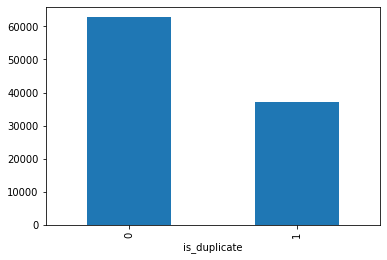

In [51]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [52]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   100000


In [53]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   62.75%

~> Question pairs are Similar (is_duplicate = 1):
   37.25%


**3.2: Number of unique questions**

In [54]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

Total number of  Unique Questions are: 165931

Number of unique questions that appear more than one time: 19446 (11.719329118730075%)

Max number of times a single question is repeated: 32



**3.3: Plot Representing Unique and Repeated QUestions**

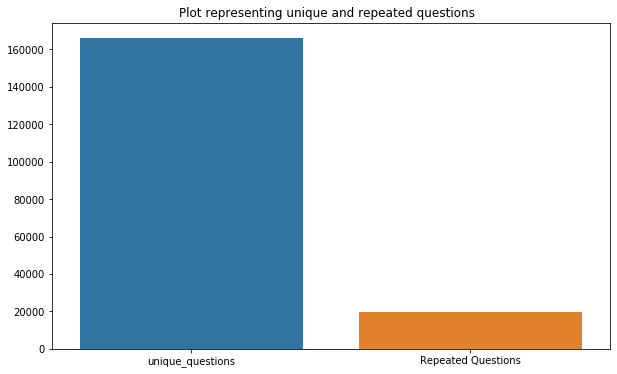

In [55]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

**3.4: Checking Duplicates**

In [56]:
#checking whether there are any repeated pair of questions
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


**3.5: Number of occurrences of each question**

Maximum number of times a single question is repeated: 32



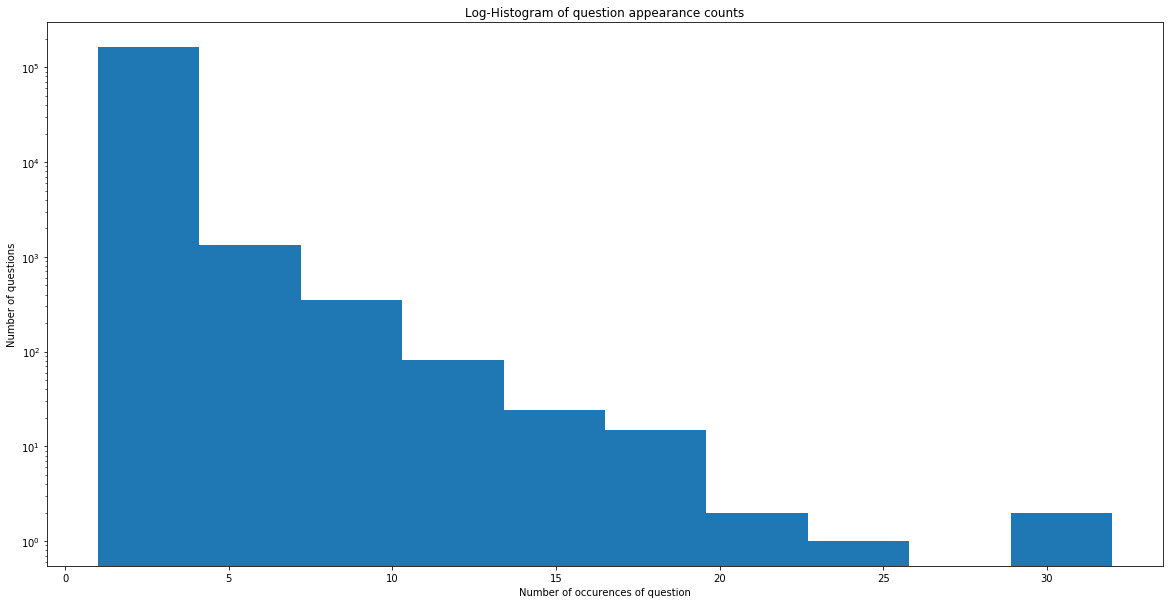

In [57]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=10)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

**3.5: Checking for NULL values**

In [58]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

**3.6: Train Test Split**

In [59]:
# train test split
y_true = df['is_duplicate'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y_true, test_size=0.33, stratify=y_true)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in cross-val data :",X_cv.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (44890, 6)
Number of data points in cross-val data : (22110, 6)
Number of data points in test data : (33000, 6)


**Basic Feature Extraction for train set**

In [60]:
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/X_train_fe_without_preprocessing.csv'):
    X_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/train.csv",encoding='latin-1')
else:
    X_train['freq_qid1'] = X_train.groupby('qid1')['qid1'].transform('count') 
    X_train['freq_qid2'] = X_train.groupby('qid2')['qid2'].transform('count')
    X_train['q1len'] = X_train['question1'].str.len() 
    X_train['q2len'] = X_train['question2'].str.len()
    X_train['q1_n_words'] = X_train['question1'].apply(lambda row: len(row.split(" ")))
    X_train['q2_n_words'] = X_train['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    X_train['word_Common'] = X_train.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    X_train['word_Total'] = X_train.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    X_train['word_share'] = X_train.apply(normalized_word_share, axis=1)

    X_train['freq_q1+q2'] = X_train['freq_qid1']+X_train['freq_qid2']
    X_train['freq_q1-q2'] = abs(X_train['freq_qid1']-X_train['freq_qid2'])

    X_train.to_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/X_train_fe_without_preprocessing_train.csv", index=False)

X_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
73521,73521,126160,91789,What is the meaning of Ishraq in Islam?,"What does Islam say about homosexuals, their r...",0,1,1,39,139,8,23,2.0,29.0,0.068966,2,0
18729,18729,35463,35464,What qualities does a chief design officer need?,Do you think an engineering leader should a vi...,0,1,1,48,85,8,14,3.0,21.0,0.142857,2,0
57327,57327,24201,60124,What proof is there of life after death?,Is there any hard proof of life after death?,1,3,1,40,44,8,9,7.0,17.0,0.411765,4,2
52420,52420,92817,92818,What are the chances that I don't losr my slot...,Why do Quora allow anonymous fake questions fr...,0,1,1,91,80,17,11,0.0,27.0,0.000000,2,0
33882,33882,62178,62179,Why does Quora Android app is not working?,Why isn't the Quora Android app that good?,0,1,1,42,42,8,8,4.0,16.0,0.250000,2,0


**Basic Feature Extraction for cross set**

In [61]:
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/X_cv_fe_without_preprocessing.csv'):
    X_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/X_cv_fe_without_preprocessing.csv",encoding='latin-1')
else:
    X_cv['freq_qid1'] = X_cv.groupby('qid1')['qid1'].transform('count') 
    X_cv['freq_qid2'] = X_cv.groupby('qid2')['qid2'].transform('count')
    X_cv['q1len'] = X_cv['question1'].str.len() 
    X_cv['q2len'] = X_cv['question2'].str.len()
    X_cv['q1_n_words'] = X_cv['question1'].apply(lambda row: len(row.split(" ")))
    X_cv['q2_n_words'] = X_cv['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    X_cv['word_Common'] = X_cv.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    X_cv['word_Total'] = X_cv.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    X_cv['word_share'] = X_cv.apply(normalized_word_share, axis=1)

    X_cv['freq_q1+q2'] = X_cv['freq_qid1']+X_cv['freq_qid2']
    X_cv['freq_q1-q2'] = abs(X_cv['freq_qid1']-X_cv['freq_qid2'])

    X_cv.to_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/X_cv_fe_without_preprocessing.csv", index=False)

X_cv.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
77658,77658,132554,132555,What is fixed pay and variable pay in salary s...,Do we get the 100% of our variable pay in Capg...,0,1,1,55,52,10,11,3.0,20.0,0.150000,2,0
66253,66253,114860,114861,Has anyone ever converted to another religion?,What's it like to convert to another religion?,1,1,1,46,46,7,8,3.0,14.0,0.214286,2,0
58065,58065,101946,101947,Can leaders belonging to 2 different political...,Was Obama a bad party leader?,0,1,1,117,29,20,6,0.0,25.0,0.000000,2,0
55223,55223,84764,97383,What are some good and cheap hotels or hostels...,What are some good and cheap hotels or hostels...,0,1,1,105,104,18,18,17.0,36.0,0.472222,2,0
88273,88273,148499,148500,Why do old radios sometimes pick up radio stat...,How do radio stations get benefits? Is it only...,0,1,1,120,54,20,11,4.0,29.0,0.137931,2,0


**Basic Feature Extraction for test set**

In [62]:
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/X_test_fe_without_preprocessing.csv'):
    X_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/X_test_fe_without_preprocessing.csv",encoding='latin-1')
else:
    X_test['freq_qid1'] = X_test.groupby('qid1')['qid1'].transform('count') 
    X_test['freq_qid2'] = X_test.groupby('qid2')['qid2'].transform('count')
    X_test['q1len'] = X_test['question1'].str.len() 
    X_test['q2len'] = X_test['question2'].str.len()
    X_test['q1_n_words'] = X_test['question1'].apply(lambda row: len(row.split(" ")))
    X_test['q2_n_words'] = X_test['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    X_test['word_Common'] = X_test.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    X_test['word_Total'] = X_test.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    X_test['word_share'] = X_test.apply(normalized_word_share, axis=1)

    X_test['freq_q1+q2'] = X_test['freq_qid1']+X_test['freq_qid2']
    X_test['freq_q1-q2'] = abs(X_test['freq_qid1']-X_test['freq_qid2'])

    X_test.to_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/X_test_fe_without_preprocessing.csv", index=False)

X_test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
79398,79398,82266,82452,How do I start from the scraps in an online bu...,How do I build an online business?,1,1,1,53,34,11,7,6.0,18.0,0.333333,2,0
93701,93701,21484,74251,How many medals will India win in Rio Olympics?,How many medals will India win in 2016 Olympics?,1,2,1,47,48,9,9,8.0,18.0,0.444444,3,1
79723,79723,91949,135671,What are some fun facts about you?,What is the fun fact about April?,0,2,1,34,33,7,7,3.0,14.0,0.214286,3,1
15373,15373,29055,29377,What is the easiest and painless way to commit...,What is the most effective way to suicide?,1,5,2,55,42,10,8,6.0,18.0,0.333333,7,3
38518,38518,69943,69944,How do I get over failure & disappointment?,"Is it possibe to avoid injury during running, ...",0,1,1,43,105,8,20,0.0,22.0,0.000000,2,0


**3.7: Analysis of some of the extracted features**

In [63]:
print ("Minimum length of the questions in question1 : " , min(X_train['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(X_train['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", X_train[X_train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", X_train[X_train['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 8
Number of Questions with minimum length [question2] : 2


**Feature: word_share**

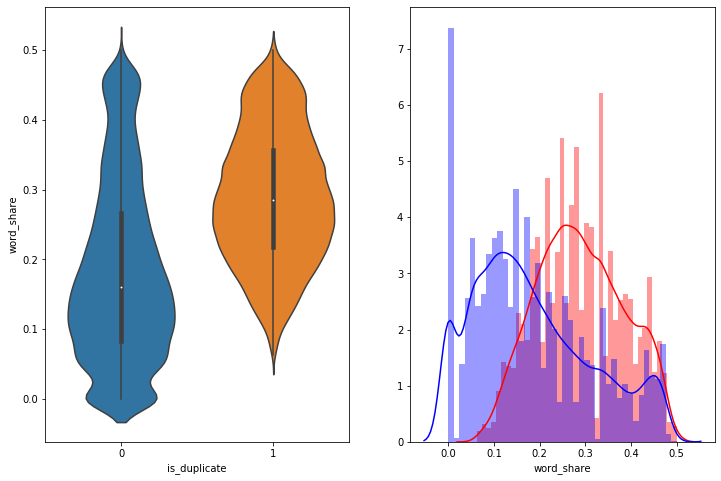

In [64]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = X_train)

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

**Feature: word common**

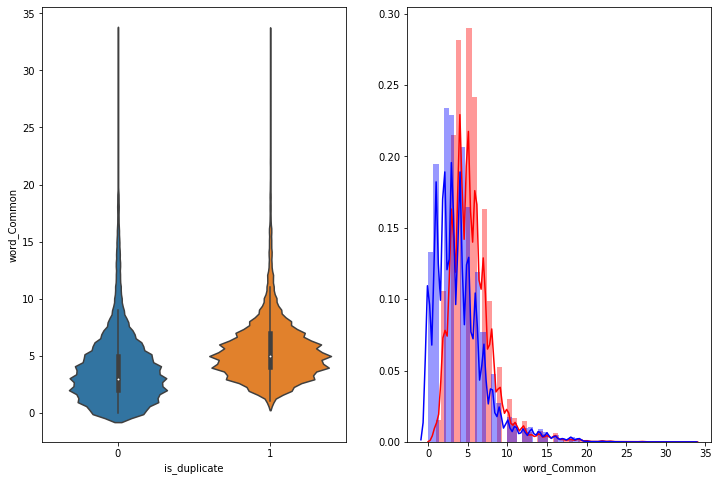

In [65]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = X_train)

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

**3.8: Preprocessing of Text**

- Removing html tags
- Removing Punctuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc.

In [66]:
import nltk
nltk.download('stopwords')
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**3.9: Advanced Feature Extraction (NLP and Fuzzy Features)**

In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [76]:
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/nlp_features_train.csv'):
    X_train= pd.read_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/nlp_features_train.csv",encoding='latin-1')
    X_train.fillna('')
else:
    print("Extracting features for train:")
#     df = pd.read_csv("drive/My Drive/Quora_assignment/train.csv")
    X_train= extract_features(X_train)
    X_train.to_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/nlp_features_train.csv", index=False)
X_train.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
73521,73521,126160,91789,what is the meaning of ishraq in islam,what does islam say about homosexuals their r...,0,1,1,39,139,8,23,2.0,29.0,0.068966,2,0,0.333322,0.083333,0.399992,0.222220,0.374995,0.130434,0.0,1.0,15.0,15.5,51,28,16,31,0.175000
18729,18729,35463,35464,what qualities does a chief design officer need,do you think an engineering leader should a vi...,0,1,1,48,85,8,14,3.0,21.0,0.142857,2,0,0.599988,0.374995,0.333322,0.166664,0.499994,0.266665,0.0,0.0,7.0,11.5,64,55,44,71,0.489796


In [77]:
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/nlp_features_cv.csv'):
    X_cv= pd.read_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/nlp_features_cv.csv",encoding='latin-1')
    X_cv.fillna('')
else:
    print("Extracting features for cv:")
#     df = pd.read_csv("drive/My Drive/Quora_assignment/cv.csv")
    X_cv= extract_features(X_cv)
    X_cv.to_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/nlp_features_cv.csv", index=False)
X_cv.head(2)

Extracting features for cv:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
77658,77658,132554,132555,what is fixed pay and variable pay in salary s...,do we get the 100 percent of our variable pay...,0,1,1,55,52,10,11,3.0,20.0,0.150000,2,0,0.399992,0.333328,0.249994,0.166664,0.299997,0.249998,0.0,0.0,2.0,11.0,50,52,46,48,0.303571
66253,66253,114860,114861,has anyone ever converted to another religion,what is it like to convert to another religion,1,1,1,46,46,7,8,3.0,14.0,0.214286,2,0,0.499988,0.399992,0.499975,0.249994,0.428565,0.333330,1.0,0.0,2.0,8.0,70,62,75,76,0.446809


In [78]:

if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/nlp_features_test.csv'):
    X_test= pd.read_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/",encoding='latin-1')
    X_test.fillna('')
else:
    print("Extracting features for test:")
#     df = pd.read_csv("drive/My Drive/Quora_assignment/test.csv")
    X_test= extract_features(X_test)
    X_test.to_csv("/content/drive/My Drive/Colab Notebooks/Quora Question PairWise Similarity/nlp_features_test.csv", index=False)
X_test.head(2)

Extracting features for test:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



token features...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

fuzzy features..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
79398,79398,82266,82452,how do i start from the scraps in an online bu...,how do i build an online business,1,1,1,53,34,11,7,6.0,18.0,0.333333,2,0,0.666644,0.499988,0.999975,0.571420,0.857131,0.545450,1.0,1.0,4.0,9.0,90,64,68,72,0.571429
93701,93701,21484,74251,how many medals will india win in rio olympics,how many medals will india win in 2016 olympics,1,2,1,47,48,9,9,8.0,18.0,0.444444,3,1,0.833319,0.833319,0.999967,0.999967,0.888879,0.888879,1.0,1.0,0.0,9.0,95,90,92,91,0.708333


**Pair plot of features**

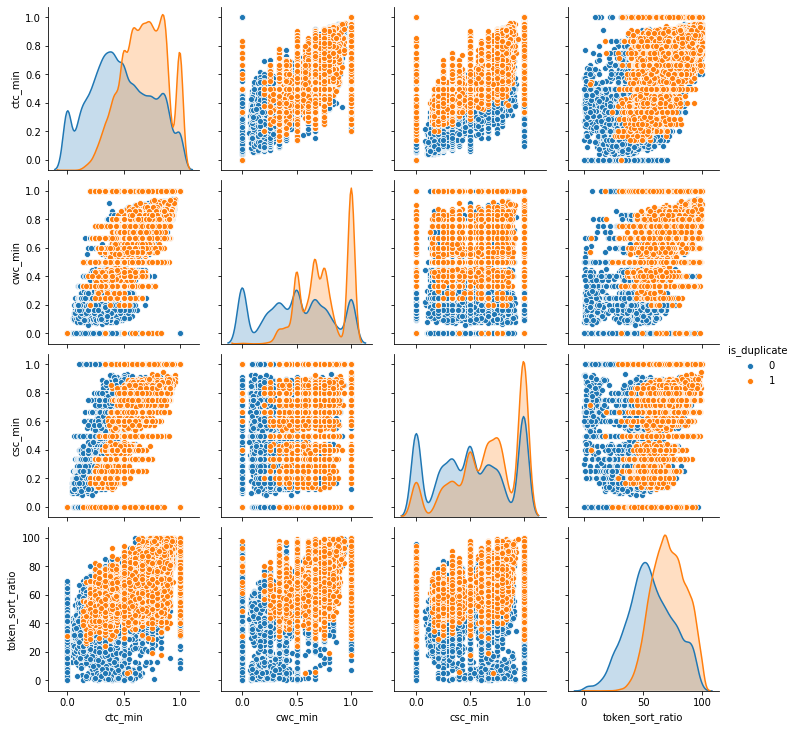

In [79]:
n = X_train.shape[0]
sns.pairplot(X_train[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

**Visualization**

In [82]:
X_trainp_subsampled = X_train[0:5000]
X = MinMaxScaler().fit_transform(X_trainp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = X_trainp_subsampled['is_duplicate'].values

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.023s...
[t-SNE] Computed neighbors for 5000 samples in 0.416s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.141507
[t-SNE] Computed conditional probabilities in 0.325s
[t-SNE] Iteration 50: error = 81.2738495, gradient norm = 0.0413364 (50 iterations in 2.305s)
[t-SNE] Iteration 100: error = 70.9717407, gradient norm = 0.0101738 (50 iterations in 2.009s)
[t-SNE] Iteration 150: error = 69.0122223, gradient norm = 0.0055886 (50 iterations in 1.811s)
[t-SNE] Iteration 200: error = 68.2451401, gradient norm = 0.0040617 (50 iterations in 1.816s)
[t-SNE] Iteration 250: error = 67.8135757, gradient norm = 0.0031879

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



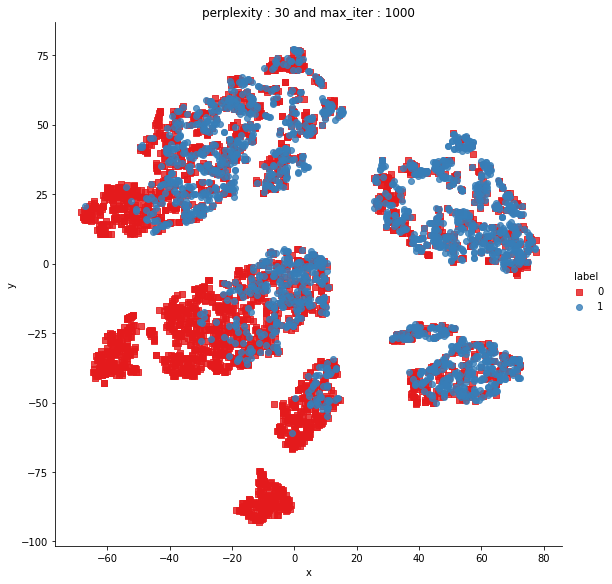

In [83]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [84]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.023s...
[t-SNE] Computed neighbors for 5000 samples in 0.402s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.141507
[t-SNE] Computed conditional probabilities in 0.314s
[t-SNE] Iteration 50: error = 84.1309967, gradient norm = 0.0380984 (50 iterations in 9.898s)
[t-SNE] Iteration 100: error = 69.9463272, gradient norm = 0.0042217 (50 iterations in 5.073s)
[t-SNE] Iteration 150: error = 68.4659424, gradient norm = 0.0018034 (50 iterations in 4.592s)
[t-SNE] Iteration 200: error = 67.9120483, gradient norm = 0.0013839 (50 iterations in 4.660s)
[t-SNE] Iteration 250: error = 67.5933838, gradient norm = 0.0009053

**Featurizing text data with tfidf weighted word-vectors**

In [0]:
from sklearn.preprocessing import normalize
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Section 4: Modeling and Prediction

In [88]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
tfidf_train_q1 =  vectorizer.fit_transform(X_train['question1'].values)
tfidf_cv_q1    =  vectorizer.transform(X_cv['question1'].values)
tfidf_test_q1  =  vectorizer.transform(X_test['question1'].values)

feat_tfidf = vectorizer.get_feature_names()
print("Train tfidf ",tfidf_train_q1.shape)
print("CV tfidf",tfidf_cv_q1.shape)
print("Test tfidf",tfidf_test_q1.shape)

Train tfidf  (44890, 5000)
CV tfidf (22110, 5000)
Test tfidf (33000, 5000)


In [101]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_cv.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (44890, 32)
Number of data points in test data : (22110, 32)
Number of data points in test data : (33000, 32)


In [100]:

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274671419024281 Class 1:  0.37253285809757186
---------- Distribution of output variable in test data ----------
Class 0:  0.6274545454545455 Class 1:  0.37254545454545457


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

**Building a random model (Finding worst-case log-loss)**

Log loss on Test Data using Random Model 0.8847479346400489


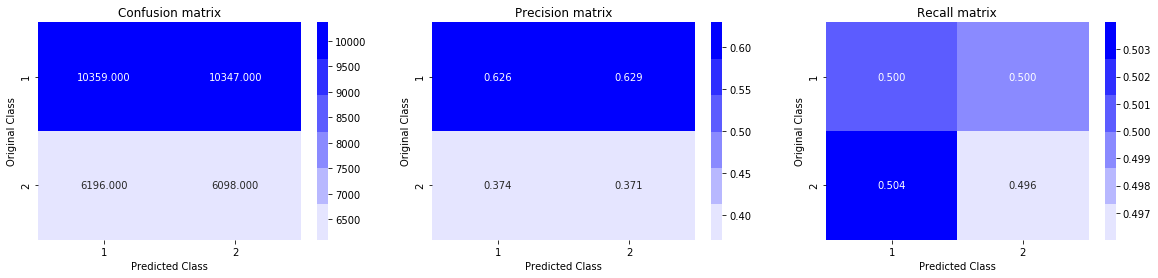

In [107]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Thank You!